## Bicycle 선수 등급 분석

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import lightgbm as lgb
from scipy.stats import mode
import re
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from lightgbm import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [35]:
def Bicycle_data_setting():
    Bicycle = pd.read_csv("2016 경륜출주표.csv", encoding='cp949')
    Bicycle_y = Bicycle['등급']
    Bicycle_dum = pd.get_dummies(Bicycle.drop("등급",axis=1))
    Bicycle_total = pd.concat([Bicycle_dum, Bicycle_y], axis=1)
    
    return Bicycle_total

Bicycle_total = Bicycle_data_setting()

In [65]:
Bicycle_total.tail()

,회차,일차,경주번호,등번,기수,나이,기어배수,승률(%),연대율(%),삼연대율(%),...,최근 3회전 성적_3일차_특우12-7,최근 3회전 성적_3일차_특우14-1,최근 3회전 성적_3일차_특우14-2,최근 3회전 성적_3일차_특우14-3,최근 3회전 성적_3일차_특우14-4,최근 3회전 성적_3일차_특우14-5,최근 3회전 성적_3일차_특우14-6,최근 3회전 성적_3일차_특우14-7,최근 3회전 성적_3일차_후 보,등급
15119,51,2,15,3,19,30,3.93,28,42,58,...,0,0,0,0,0,0,0,0,0,특선
15120,51,2,15,4,17,31,3.92,12,19,33,...,0,0,0,0,0,0,0,0,0,특선
15121,51,2,15,5,18,29,3.92,17,27,38,...,0,0,0,0,0,0,0,0,0,특선
15122,51,2,15,6,21,28,3.92,28,71,79,...,0,0,0,0,0,0,0,0,0,특선
15123,51,2,15,7,12,37,3.92,11,26,39,...,0,0,0,0,0,0,0,0,0,특선


In [66]:
Bicycle_total['등급'].value_counts()

우수    6163
선발    5243
특선    3718
Name: 등급, dtype: int64

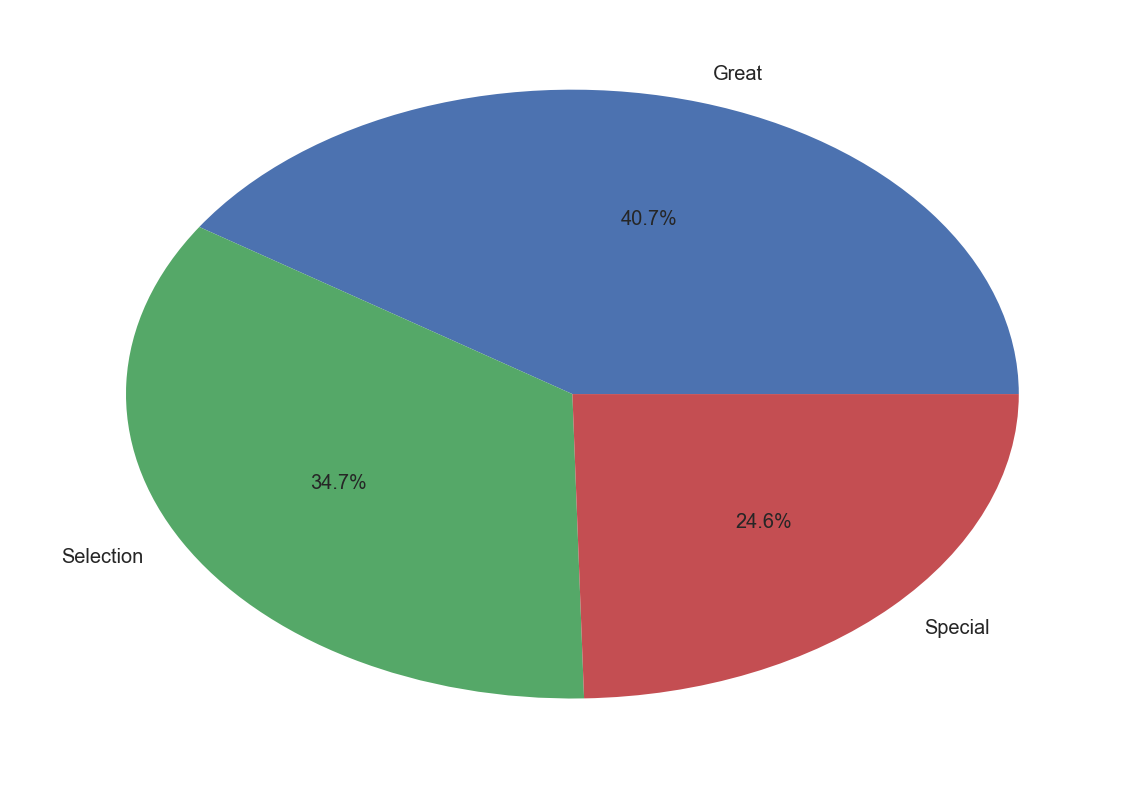

In [67]:
total_v = Bicycle_total['등급'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['Great','Selection','Special']
plt.pie(total_v, labels=labels ,autopct='%1.1f%%')
plt.show()

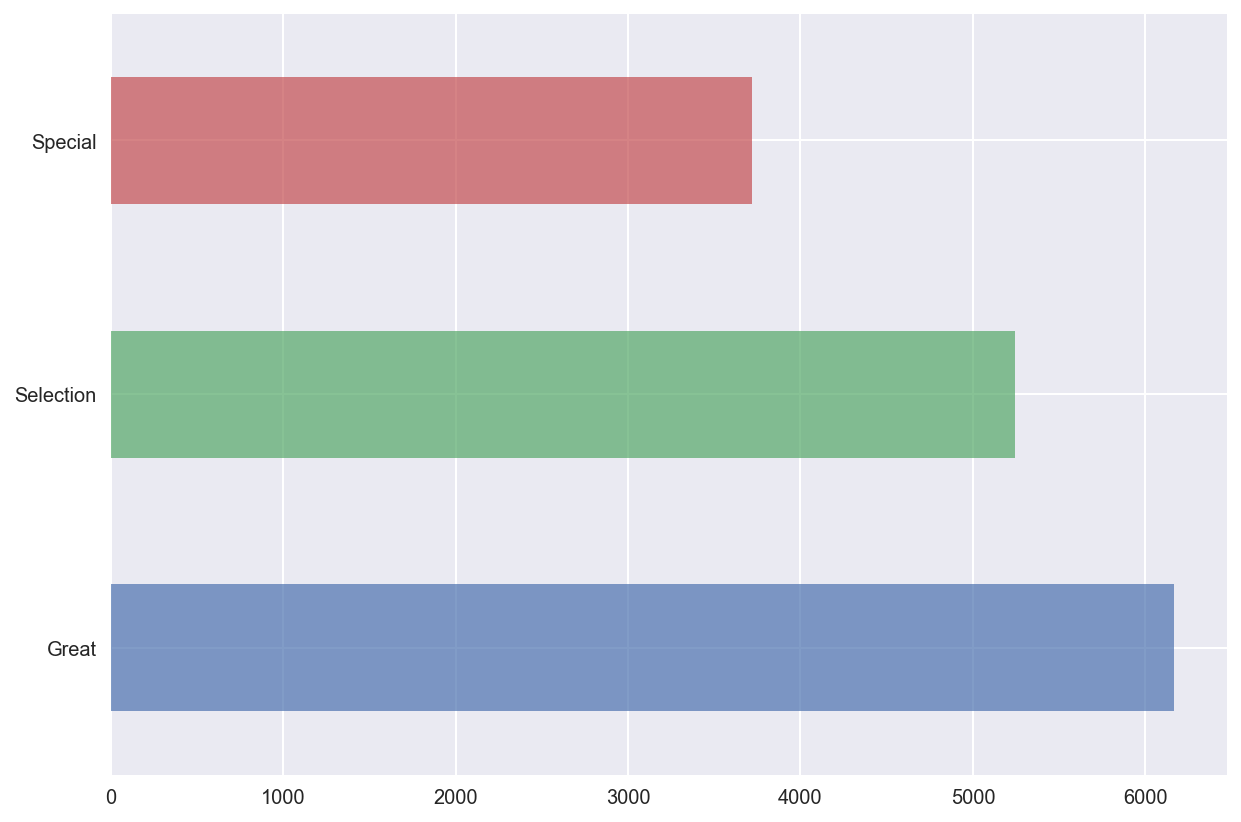

In [68]:
total_v_s = pd.Series({'Great':6163,'Selection':5243,'Special':3718})
fig = plt.figure(figsize = (10,7))
total_v_s.plot(kind="barh", align='center', alpha=0.7)
plt.show()

---

### 1. 분석

In [22]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(Bicycle_total.drop("등급", axis=1), Bicycle_total['등급'], \
                                                    test_size=0.3, random_state=0)

len(X_train_B),len(X_test_B),len(y_train_B),len(y_test_B)

(10586, 4538, 10586, 4538)

In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(Bicycle_total['등급'])
X_train = Bicycle_total.drop("등급", axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Train 

Confusion_Matrix 

[[3631    0    0]
 [   0 4318    0]
 [   0    0 2637]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      3631
         우수       1.00      1.00      1.00      4318
         특선       1.00      1.00      1.00      2637

avg / total       1.00      1.00      1.00     10586
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[1612    0    0]
 [   0 1845    0]
 [   0    0 1081]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      1612
         우수       1.00      1.00      1.00      1845
         특선       1.00      1.00      1.00      1081

avg / total       1.00      1.00      1.00      4538
 


Accuracy_Score 

1.0


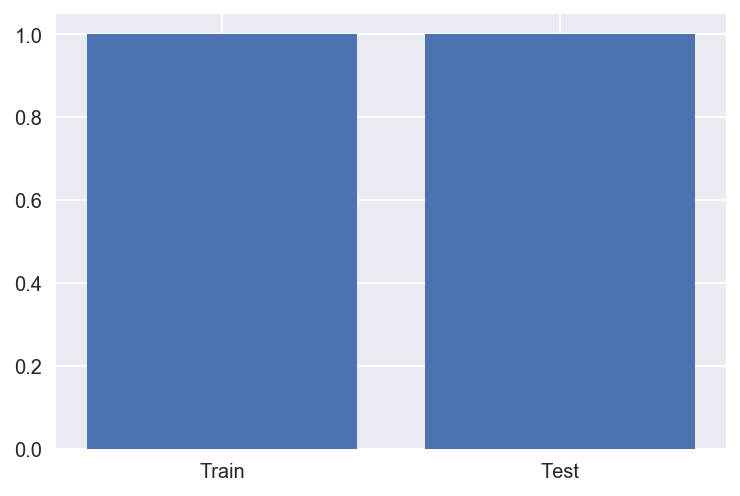

In [23]:
# def Bicycle_lgb():
    
model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
model_lgb.fit(X_train_B, y_train_B)

y_pred_l = model_lgb.predict(X_train_B)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_B, y_pred_l), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_B, y_pred_l), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_B, y_pred_l),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_B = model_lgb.predict(X_test_B)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_B, y_pred_l_B), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_B, y_pred_l_B), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_B, y_pred_l_B),2))

x="Train","Test"
y=accuracy_score(y_train_B, y_pred_l), accuracy_score(y_test_B, y_pred_l_B)
plt.bar(x,y)
plt.show()

In [32]:
plot_importance(model_lgb, figsize=(100, 100))

In [39]:
importances = model_lgb.feature_importances_
importances = pd.DataFrame(importances, columns=["importance"])

i_c = Bicycle_total.drop("등급", axis=1)
i_c = i_c.columns
i_c = pd.DataFrame(i_c, columns=["name"])
f_i = pd.concat([i_c,importances],axis=1)

f_i_BB = f_i[f_i['importance'] >= 10]

In [40]:
f_i_BB.sort_values("importance", ascending=False)

,name,importance
18,평균득점_광명,303
2,경주번호,300
19,평균득점_종합,204
1041,등급조정_현재_S3,133
1033,등급조정_현재_A1,130
1040,등급조정_현재_S2,107
0,회차,102
22,최근 3회전 성적_경주일자,100
173,경주일자_2016.12.23,92
1034,등급조정_현재_A2,76


---

### 2. Importance 10이하 정리 후 재 분석

In [52]:
X=Bicycle_total.drop("등급", axis=1)

f_i_B = list(f_i_BB["name"])

X_L = X.filter(f_i_B, axis=1)
y_L = Bicycle_total['등급']

In [53]:
X_L.tail()

,회차,경주번호,나이,입상,출전횟수,입상전법_추입,평균득점_광명,평균득점_종합,최근 1회전 성적_경주일자,최근 2회전 성적_경주일자,...,등급조정_현재_A2,등급조정_현재_A3,등급조정_현재_B1,등급조정_현재_B2,등급조정_현재_S1,등급조정_현재_S2,등급조정_현재_S3,등급조정_이전_S1,등급조정_이전_S3,최근 3회전 성적_1일차_특선12-7
15119,51,15,30,33,57,16,97.341,97.341,1223,1202,...,0,0,0,0,0,1,0,0,1,0
15120,51,15,31,19,58,5,96.162,96.842,1223,1202,...,0,0,0,0,0,0,1,0,0,0
15121,51,15,29,20,52,9,94.687,94.636,1209,1111,...,0,0,0,0,0,0,1,0,0,0
15122,51,15,28,46,58,8,104.532,103.782,1223,1125,...,0,0,0,0,1,0,0,1,0,0
15123,51,15,37,22,57,7,93.215,93.215,1223,1209,...,0,0,0,0,0,0,1,0,1,0


In [56]:
y_L.tail()

15119    특선
15120    특선
15121    특선
15122    특선
15123    특선
Name: 등급, dtype: object

In [57]:
X_train_BB, X_test_BB, y_train_BB, y_test_BB = train_test_split(X_L, y_L, \
                                                    test_size=0.3, random_state=0)

len(X_train_BB),len(X_test_BB),len(y_train_BB),len(y_test_BB)

(10586, 4538, 10586, 4538)

In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(y_L)
X_train = X_L

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Train 

Confusion_Matrix 

[[3631    0    0]
 [   0 4318    0]
 [   0    0 2637]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      3631
         우수       1.00      1.00      1.00      4318
         특선       1.00      1.00      1.00      2637

avg / total       1.00      1.00      1.00     10586
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[1612    0    0]
 [   0 1845    0]
 [   0    0 1081]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      1612
         우수       1.00      1.00      1.00      1845
         특선       1.00      1.00      1.00      1081

avg / total       1.00      1.00      1.00      4538
 


Accuracy_Score 

1.0


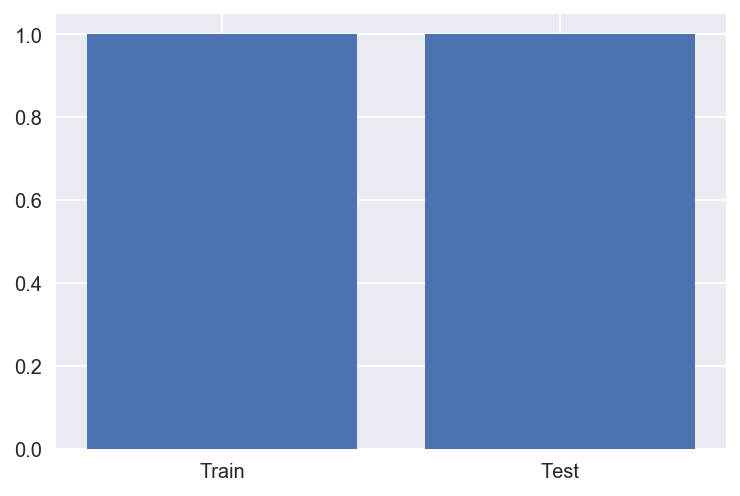

In [61]:
# def BBicycle_lgb():
    
model_lgb_f = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
model_lgb_f.fit(X_train_BB, y_train_BB)

y_pred_l = model_lgb_f.predict(X_train_BB)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_BB, y_pred_l), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_BB, y_pred_l), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_BB, y_pred_l),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_BB = model_lgb_f.predict(X_test_BB)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_BB, y_pred_l_BB), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_BB, y_pred_l_BB), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_BB, y_pred_l_BB),2))

x="Train","Test"
y=accuracy_score(y_train_BB, y_pred_l), accuracy_score(y_test_BB, y_pred_l_BB)
plt.bar(x,y)
plt.show()

In [62]:
plot_importance(model_lgb_f, figsize=(100, 100))

In [63]:
importances = model_lgb_f.feature_importances_
importances = pd.DataFrame(importances, columns=["importance"])

i_c = Bicycle_total.drop("등급", axis=1)
i_c = i_c.columns
i_c = pd.DataFrame(i_c, columns=["name"])
f_i = pd.concat([i_c,importances],axis=1)

f_i_BB = f_i[f_i['importance'] >= 10]

In [64]:
f_i_BB.sort_values("importance", ascending=False)

,name,importance
6,기어배수,308.0
1,일차,301.0
7,승률(%),222.0
22,최근 3회전 성적_경주일자,132.0
15,입상전법_젖히기,130.0
21,최근 2회전 성적_경주일자,107.0
10,주회수,98.0
14,입상전법_선행,92.0
0,회차,91.0
16,입상전법_추입,77.0


---

추후 진행

In [7]:
# from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense

# np.random.seed(0)
# model = Sequential()
# model.add(SimpleRNN(10, input_shape=(15124, 44)))
# model.add(Dense(1, activation="linear"))
# model.compile(loss='mse', optimizer='sgd')

In [ ]:
# from keras.layers import TimeDistributed

# model2 = Sequential()
# model2.add(SimpleRNN(10, return_sequences=True, input_shape=(44, 1)))
# model2.add(TimeDistributed(Dense(1, activation="linear")))
# model2.compile(loss='mse', optimizer='sgd')

In [ ]:
# from scipy.linalg import toeplitz
# S = np.fliplr(toeplitz(np.r_[Bicycle[-1], np.zeros(s.shape[0] - 2)], s[::-1]))
# S[:5, :3]

In [ ]:
# history = model.fit(Bicycle.drop("등급",axis=1), Bicycle['등급'], epochs=100, verbose=0)